- raw data의 description, dictionary를 통해 데이터의 각 column들과 row의 의미를 이해하는 기술
- 결측치 처리 및 데이터필터링 기술
- 누구나 이해하기 쉬운 시각화를 하는 기술

In [1]:
import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('fivethirtyeight')
from matplotlib.ticker import FuncFormatter
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import spacy
from sklearn.feature_extraction.text import CountVectorizer
import os

import warnings

In [2]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/멀캠_빅데이터_7_8/dataset_feedback/train.csv')

데이터셋은 6-12학년들이 작성한 논설문이며, 전문 평가자가 해당글에 주석(라벨링)을 달았다.
테스트 데이터는 약 10k문서이다.
우리의 목적은 해당 라벨링을 예측하는 것이다. 각 논설문을 수사적, 논증적 요소로 나우고, 나누 각 요소들을 분류해야합니다.
- Lead : 독자들의 관심을 끄는 장치, 통계, 인용 설명등 포함됨
- Position : 주요 질문에 대한 의견 또는 결론
- Claim : Position을 뒷받침하는 주장
- Counterclaim : Position에 반하는 Claim 혹은 이유
- Rebuttal :  Counterclaim에 반박하는 내용
- Evidence : Claim, Counterclaim, Rebuttal의 뒷바침 아이디어 또는 예시
- Concluding Statement : Claim을 한번 더 언급하는 결론

학습데이터는 개별논설문가. .txt파일로 주석이 .csv파일로 구성됩니다. 논설문의 일부는 주석이 없다.

In [3]:
train.head()

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
0,423A1CA112E2,1.622628e+12,8.0,229.0,Modern humans today are always on their phone....,Lead,Lead 1,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...
1,423A1CA112E2,1.622628e+12,230.0,312.0,They are some really bad consequences when stu...,Position,Position 1,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59
2,423A1CA112E2,1.622628e+12,313.0,401.0,Some certain areas in the United States ban ph...,Evidence,Evidence 1,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
3,423A1CA112E2,1.622628e+12,402.0,758.0,"When people have phones, they know about certa...",Evidence,Evidence 2,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...
4,423A1CA112E2,1.622628e+12,759.0,886.0,Driving is one of the way how to get around. P...,Claim,Claim 1,139 140 141 142 143 144 145 146 147 148 149 15...


In [6]:
with open('/content/drive/MyDrive/Colab Notebooks/멀캠_빅데이터_7_8/dataset_feedback/train/0000D23A521A.txt', 'r') as f:
    txt = f.read()
print(txt)

Some people belive that the so called "face" on mars was created by life on mars. This is not the case. The face on Mars is a naturally occuring land form called a mesa. It was not created by aliens, and there is no consiracy to hide alien lifeforms on mars. There is no evidence that NASA has found that even suggests that this face was created by aliens.

A mesa is a naturally occuring rock formation, that is found on Mars and Earth. This "face" on mars only looks like a face because humans tend to see faces wherever we look, humans are obviously extremely social, which is why our brain is designed to recognize faces.

Many conspiracy theorists believe that NASA is hiding life on Mars from the rest of the world. These people would be very wrong. If NASA found life on Mars, then they would get millions of people's attention. NASA's budget would increase drasticly, which means that their workers would get paid more. There is no good reason that NASA would hide life on Mars from the rest 

In [7]:
sample = train.loc[train.id == '0000D23A521A']
sample

,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring
59951,0000D23A521A,1.617735e+12,0.0,170.0,"Some people belive that the so called ""face"" o...",Position,Position 1,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...
59952,0000D23A521A,1.617735e+12,170.0,357.0,"It was not created by aliens, and there is no ...",Evidence,Evidence 1,34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 4...
59953,0000D23A521A,1.617735e+12,358.0,438.0,"A mesa is a naturally occuring rock formation,...",Evidence,Evidence 2,69 70 71 72 73 74 75 76 77 78 79 80 81 82 83
59954,0000D23A521A,1.617735e+12,438.0,626.0,"This ""face"" on mars only looks like a face bec...",Claim,Claim 1,84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 9...
59955,0000D23A521A,1.617735e+12,627.0,722.0,Many conspiracy theorists believe that NASA is...,Counterclaim,Counterclaim 1,117 118 119 120 121 122 123 124 125 126 127 12...
59956,0000D23A521A,1.617735e+12,722.0,836.0,These people would be very wrong. If NASA foun...,Rebuttal,Rebuttal 1,134 135 136 137 138 139 140 141 142 143 144 14...
59957,0000D23A521A,1.617735e+12,836.0,1014.0,"NASA's budget would increase drasticly, which ...",Evidence,Evidence 3,154 155 156 157 158 159 160 161 162 163 164 16...
59958,0000D23A521A,1.617735e+12,1015.0,1343.0,"So, NASA is not hiding life on Mars from us, a...",Concluding Statement,Concluding Statement 1,186 187 188 189 190 191 192 193 194 195 196 19...


- id : 논설문에 대한 ID코드
- discourse_id : discourse 요소에 대한 ID 코드
- discourse_start : 논설문에서 discourse가 시작하는 위치 (text의 index)
- discourse_end : 논설문에서 discourse가 끝나는 위치 (text의 index)
- discourse_text : discourse의 text
- discourse_type : discourse의 구분
- discourse_type_num : 몇 번째 discourse
- predictionstring : 예측에 필요한 훈련 샘플의 단어 인덱스

In [8]:
sample['discourse_text'][59951]

'Some people belive that the so called "face" on mars was created by life on mars. This is not the case. The face on Mars is a naturally occuring land form called a mesa. '

In [12]:
# discourse_text, discourse_end의 숫자가 무엇을 의미하는지 확인 해보자!
txt[170:357] # txt의 index

'It was not created by aliens, and there is no consiracy to hide alien lifeforms on mars. There is no evidence that NASA has found that even suggests that this face was created by aliens.\n'

In [11]:
# 단어 갯수 확인
len(txt[0:170].split())

35

## discourse_text와 predictionstring의 길이

In [13]:
train['discourse_len'] = train['discourse_text'].apply(lambda x: len(x.split()))
train['pred_len'] = train['predictionstring'].apply(lambda x: len(x.split()))

cols_to_display = ['discourse_id', 'discourse_text', 'discourse_type', 'predictionstring', 'discourse_len', 'pred_len']
train[cols_to_display].head()

,discourse_id,discourse_text,discourse_type,predictionstring,discourse_len,pred_len
0,1.622628e+12,Modern humans today are always on their phone....,Lead,1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...,44,44
1,1.622628e+12,They are some really bad consequences when stu...,Position,45 46 47 48 49 50 51 52 53 54 55 56 57 58 59,15,15
2,1.622628e+12,Some certain areas in the United States ban ph...,Evidence,60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75,16,16
3,1.622628e+12,"When people have phones, they know about certa...",Evidence,76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 9...,63,63
4,1.622628e+12,Driving is one of the way how to get around. P...,Claim,139 140 141 142 143 144 145 146 147 148 149 15...,24,24


In [14]:
print(f"discourse의 총 갯수 : {len(train)}" )
print(f"discourse_text와 predictionstring의 길이가 다른 discourse 개수: {len(train.loc[train.discourse_len != train.pred_len][cols_to_display])}")

discourse의 총 갯수 : 144293
discourse_text와 predictionstring의 길이가 다른 discourse 개수: 468


In [15]:
sample = train.loc[107]
sample

id                                                         C3811E7F1750
discourse_id                                            1622473475289.0
discourse_start                                                  1641.0
discourse_end                                                    1754.0
discourse_text        if we would just make stricker laws for phone ...
discourse_type                                     Concluding Statement
discourse_type_num                               Concluding Statement 1
predictionstring      303 304 305 306 307 308 309 310 311 312 313 31...
discourse_len                                                        19
pred_len                                                             18
Name: 107, dtype: object

In [16]:
print(sample.discourse_text)
print(len(sample.discourse_text.split()))

if we would just make stricker laws for phone an driving the people would stop because of the consequences.      
19


In [17]:
print(sample.predictionstring)
print(len(sample.predictionstring.split()))

303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320
18


In [18]:
train_txt_list = glob('/content/drive/MyDrive/Colab Notebooks/멀캠_빅데이터_7_8/dataset_feedback/train/*.txt')
text_txt_list = glob('/content/drive/MyDrive/Colab Notebooks/멀캠_빅데이터_7_8/dataset_feedback/test/*.txt')

In [19]:
for path in train_txt_list:
    if 'C3811E7F1750' in path:
        with open(path, 'r') as f:
            sample_txt = f.read()
print(sample_txt)

BOOM!! You're on I-75 on the ground bleeding out watching everyone surrounding you, calling 911.

At this point you're thinking to yourself, "why the freak did this happen?" A couple hours later you found out an adult was on his phone texting and driving before the wreck happened, which is the most selfish thing to do while driving. Putting your life and other's lives in danger just so you can send a stupid text to your girl/boyfriend is completely selfish. I firmly believe that we need stricter phone laws to in jail people.

Texting while driving is in the top five causes for deaths, and yet many states do not have laws against it. We need to stand together united and encourage our Congressmen to pass laws in order to combat this distraction.

and be mature and adult-like and discuss ways to not further endanger each other.

Cellphones are brain washing us to think we always need it, but I know we can break free from this horrible device with a little hard work we can make a change. W

In [20]:
print('원래 discourse')
print(sample.discourse_text)
print()
print(f"predictionstring 기준 text")
print(' '.join(sample_txt.split()[303:321]))

원래 discourse
if we would just make stricker laws for phone an driving the people would stop because of the consequences.      

predictionstring 기준 text
we would just make stricker laws for phone an driving the people would stop because of the consequences.


## discourse_type별 길이, 빈도, 상대적 위치

discourse_type의 길이, 빈도, 위치는 discourse_type의 각 라벨들과 연관이 있다.

### discourse_type의 길이

AttributeError: ignored

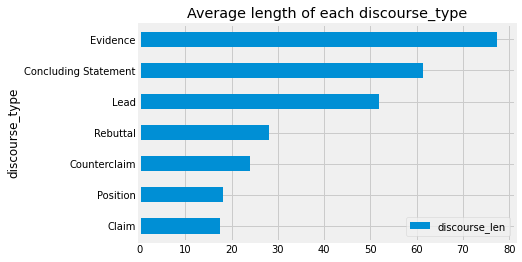

In [21]:
discourse_avg_len = train[['discourse_type', 'discourse_len']].groupby('discourse_type').mean().sort_values(by='discourse_len')
ax = discourse_avg_len.plot(kind='barh', title='Average length of each discourse_type')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

### discourse_type 빈도

AttributeError: ignored

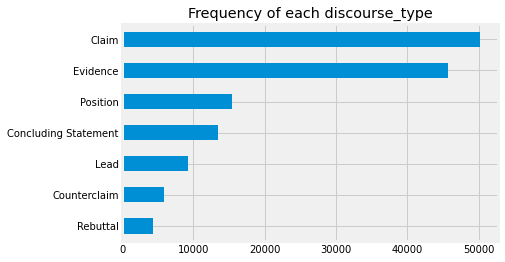

In [22]:
discourse_type_freq = train['discourse_type'].value_counts(ascending = True)
ax = discourse_type_freq.plot(kind='barh', title='Frequency of each discourse_type')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

AttributeError: ignored

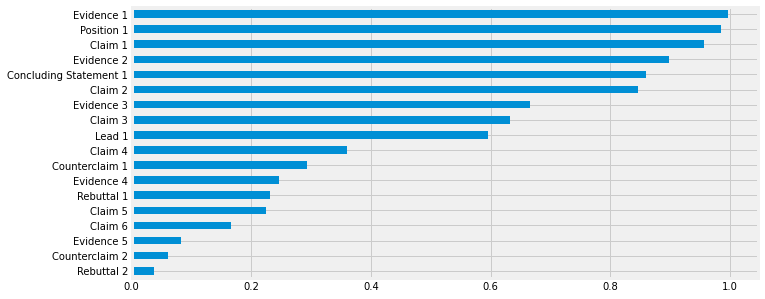

In [23]:
total_essay_num = len(train_txt_list)
discourse_type_num_freq = train['discourse_type_num'].value_counts(ascending = True)/total_essay_num
ax = discourse_type_num_freq.loc[discourse_type_num_freq>0.03].plot(kind='barh', figsize=(10,5))
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

### 상대적 위치

In [ ]:
text_length = []
for path in tqdm(train_txt_list):
    text_path = Path(path)
    with open(text_path, 'r') as f:
        text_length.append([text_path.stem,len(f.read().strip()), len(f.read().split())])
text_length_df = pd.DataFrame(text_length, columns = ['id', 'text_length', 'text_words_num'])
train = pd.merge(train, text_length_df, how='left', on='id')
train['relative_start'] = train['discourse_start']/train['text_length']
train['relative_end'] = train['discourse_end']/train['text_length']

  0%|          | 0/15594 [00:00<?, ?it/s]